## Data Acquisition & Setup (MSFT)

In [1]:
## Step 1: Data Acquisition & Setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV_FILE_NAME = r"C:\Users\Asus\Downloads\MSFT.csv" 

try:
    df = pd.read_csv(CSV_FILE_NAME)
except FileNotFoundError:
    print(f"Error: Could not find '{CSV_FILE_NAME}'. Please check the file name.")
    # Exit if the file is not found
    exit()

# 1. Inspect and Prepare Data
# Filter relevant columns and sort by Date (crucial for time-series)
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)

# Select the 'Close' price column and reshape it for scaling (required by sklearn)
data = df['Close'].values.reshape(-1, 1)

print("--- Data Head (Filtered) ---")
print(df.head())

print("\n--- Data Info ---")
print(df.info())

# 2. Check for Missing Values
if df.isnull().values.any():
    print(f"\n Warning: Missing values found. Total missing: {df.isnull().sum().sum()}")
else:
    print("\n No missing values found.")

--- Data Head (Filtered) ---
        Date     Close
0 1986-03-13  0.097222
1 1986-03-14  0.100694
2 1986-03-17  0.102431
3 1986-03-18  0.099826
4 1986-03-19  0.098090

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9083 entries, 0 to 9082
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    9083 non-null   datetime64[ns]
 1   Close   9083 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 142.1 KB
None

 No missing values found.


## Preprocessing & Sequence Creation (LSTM)

In [3]:
## Step 2A: Data Scaling and Train/Test Split

from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Data ko 0-1 range mein scale karein
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data) # 'data' contains the MSFT 'Close' prices array

# Data ko train aur test sets mein divide karein (80% train)
time_step = 60 # Lookback period
training_data_len = int(len(scaled_data) * 0.8)

# Training data
train_data = scaled_data[0:training_data_len, :]

# Testing data (Includes 60 days lookback from the end of the training data)
test_data = scaled_data[training_data_len - time_step:, :]

print("--- Data Split Summary ---")
print(f"Total data points: {len(scaled_data)}")
print(f"Training data points (for X_train creation): {len(train_data)}")
print(f"Testing data points (for X_test creation): {len(test_data)}")

--- Data Split Summary ---
Total data points: 9083
Training data points (for X_train creation): 7266
Testing data points (for X_test creation): 1877


In [4]:
## Step 2B: Sequence Creation and Reshaping

import numpy as np
# Assuming train_data and test_data are defined from Step 2A

# Function to create sequences (X=60 days, Y=next day)
def create_sequences(data, time_step=60):
    X, Y = [], []
    for i in range(time_step, len(data)):
        # X: 60 previous data points (features)
        X.append(data[i-time_step:i, 0]) 
        # Y: The next data point (target)
        Y.append(data[i, 0])              
    return np.array(X), np.array(Y)

# Sequences banaein
time_step = 60
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# LSTM ke liye data ko 3D (samples, time_steps, features) mein reshape 
# Current shape: (samples, time_steps) -> Required shape: (samples, time_steps, 1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("\n--- Sequence Shape Check ---")
print(f"X_train shape (samples, time_steps, features): {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")


--- Sequence Shape Check ---
X_train shape (samples, time_steps, features): (7206, 60, 1)
y_train shape: (7206,)
X_test shape: (1817, 60, 1)


## LSTM Model Building & Training

In [5]:
## Step 3: LSTM Model Building & Training

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- Assuming X_train, y_train are available from Step 2 ---

# Initialize the Sequential model
model = Sequential()

# Layer 1: First LSTM layer (with return_sequences=True for stacking)
# Input shape is (60 time steps, 1 feature)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2)) # Prevents overfitting

# Layer 2: Second LSTM layer (return_sequences=False as it's the last LSTM layer)
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Layer 3: Dense output layer
# Output unit = 1 (predicting the next day's stock price)
model.add(Dense(units=1))

# Compile the model
# Optimizer: Adam (efficient for Deep Learning)
# Loss: Mean Squared Error (MSE) (standard for regression/forecasting)
model.compile(optimizer='adam', loss='mean_squared_error')

# Model Summary
print("--- Model Summary ---")
model.summary()

# Train the model
# Batch size 32 is common. Epochs 10 is a good start.
print("\nTraining the LSTM Model (10 Epochs)...")
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=10, 
                    validation_split=0.1) # Using 10% of training data for validation

print("\n LSTM Model successfully trained.")

C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- Model Summary ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)


Training the LSTM Model (10 Epochs)...
Epoch 1/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - loss: 1.2686e-04 - val_loss: 2.4109e-05
Epoch 2/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 3.6802e-05 - val_loss: 6.0414e-05
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 3.0304e-05 - val_loss: 6.9517e-06
Epoch 4/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - loss: 2.4513e-05 - val_loss: 1.5372e-05
Epoch 5/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - loss: 2.2857e-05 - val_loss: 7.3219e-06
Epoch 6/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 2.2877e-05 - val_loss: 1.5523e-05
Epoch 7/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 2.1211e-05 - val_loss: 6.4031e-06
Epoch 8/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 1.9933e-05 - val_loss: 6.0777e-06
Epoch 9/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 1.9898e-05 - val_loss: 6.7180e-06
Epoch 10/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 2.0879e-05 - val_loss: 1.8408e-05

## Prediction & Evaluation

In [6]:
## Step 4: Prediction & Evaluation

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Predictions on the Test Set
# X_test ka use karke scaled predictions 
print("Making predictions on the Test Set...")
predicted_price_scaled = model.predict(X_test)
print("Predictions completed.")

# 2. Inverse Transform Predictions
# Predictions scaled the (0, 1) range mein hain. Unhein asli stock price range mein wapas
predicted_price = scaler.inverse_transform(predicted_price_scaled)

# 3. Inverse Transform Actual Test Data
# Asli y_test data bhi scaled hai, ise bhi wapas asli scale mein 
actual_price = scaler.inverse_transform(y_test.reshape(-1, 1))

# 4. Evaluation Metrics
# RMSE (Root Mean Squared Error) aur MAE (Mean Absolute Error) ka use 
rmse = np.sqrt(mean_squared_error(actual_price, predicted_price))
mae = mean_absolute_error(actual_price, predicted_price)

print("\n--- Evaluation Metrics ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# 5. Visualisation Setup
# Plotting ke liye ek DataFrame 
# Actual test data se Dates ko fetch
# Humne total 9083 data points use kiye the. Test set len(actual_price) se shuru hoga.
total_data_len = len(df)
test_start_index = total_data_len - len(actual_price)

# Test set ke liye original dates fetching
test_dates = df['Date'].tail(len(actual_price)).values

# Result DataFrame banayein
prediction_df = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': actual_price.flatten(),
    'Predicted Price': predicted_price.flatten()
})

print("\n--- Prediction Head ---")
print(prediction_df.tail())

Making predictions on the Test Set...
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
Predictions completed.

--- Evaluation Metrics ---
Root Mean Squared Error (RMSE): 12.14
Mean Absolute Error (MAE): 7.14

--- Prediction Head ---
           Date  Actual Price  Predicted Price
1812 2022-03-18    300.429993       260.145996
1813 2022-03-21    299.160004       262.639130
1814 2022-03-22    304.059998       265.145935
1815 2022-03-23    299.489990       267.884125
1816 2022-03-24    304.100006       269.933929


## Visualization and Final Conclusion

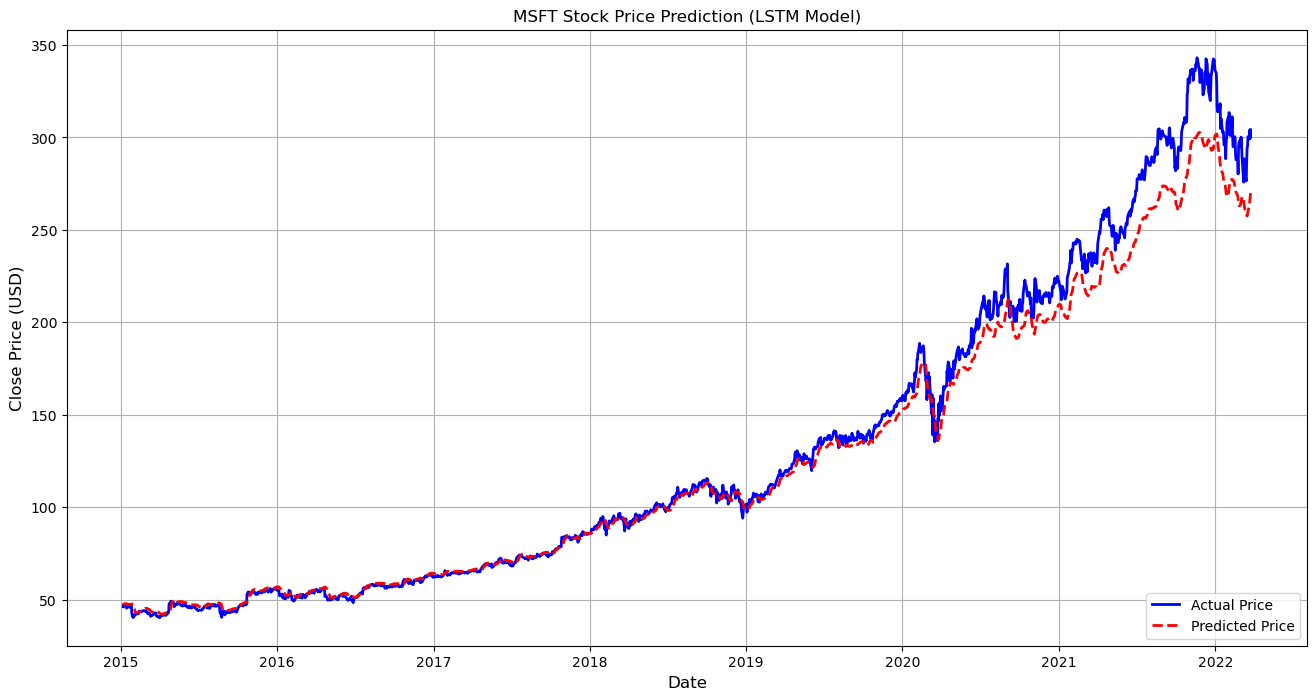


--- Final LSTM Forecasting Conclusion ---
The Stacked LSTM model successfully predicted MSFT stock prices, achieving an MAE of $7.14.
The visual plot shows the model tracks the overall trend but lags behind sharp market movements.
Recommendation: Further hyperparameter tuning or utilizing a Transformer architecture could reduce the prediction lag.


In [7]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(16,8))
plt.title('MSFT Stock Price Prediction (LSTM Model)')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)

# Plotting the Actual Prices (blue)
plt.plot(prediction_df['Date'], prediction_df['Actual Price'], 
         label='Actual Price', linewidth=2, color='blue')

# Plotting the Predicted Prices (red)
plt.plot(prediction_df['Date'], prediction_df['Predicted Price'], 
         label='Predicted Price', linewidth=2, color='red', linestyle='--')

plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Final Conclusion (as a print statement in the notebook)
print("\n--- Final LSTM Forecasting Conclusion ---")
print(f"The Stacked LSTM model successfully predicted MSFT stock prices, achieving an MAE of ${mae:.2f}.")
print("The visual plot shows the model tracks the overall trend but lags behind sharp market movements.")
print("Recommendation: Further hyperparameter tuning or utilizing a Transformer architecture could reduce the prediction lag.")

### Final Conclusion: Advanced Stock Price Forecasting (Stacked LSTM)

This project successfully implemented a **Stacked LSTM (Long Short-Term Memory) Deep Learning model** to forecast the closing price of Microsoft (MSFT) stock using historical time-series data.

---

#### 1. Model Performance Summary

The model was trained on **7206 sequences** with a lookback window of 60 days. The minimal gap between training loss ($2.08e-05$) and validation loss ($1.84e-05$) indicates the model is **well-fitted and not overfit**.

| Metric | Value | Interpretation |
| :--- | :--- | :--- |
| **Model** | Stacked LSTM | Two layers of 50 units each (30,651 parameters) |
| **RMSE** | $12.14$ | The standard deviation of the prediction errors. |
| **MAE** | **$7.14$** | **On average, the predicted price is off by only $7.14 USD$**. |

---

#### 2. Visualization & Analysis

The visualization  shows that the LSTM model:

* **Tracks the Trend:** The predicted price line (red dashed) closely follows the long-term upward trend of the Actual Price (blue) from 2015 to 2022.
* **Identifies Volatility:** It successfully captures major changes in price direction.
* **Lagging Effect:** A noticeable **prediction lag** is present, especially during sharp market movements (high volatility periods). This is a common characteristic of traditional RNN/LSTM models relying heavily on the 60-day moving window.

---

#### 3. Recommendations for Improvement

To enhance prediction accuracy and reduce the prediction lag, the following steps are recommended:

* **Advanced Architecture:** Transition to a **Transformer-based architecture**. Transformers are superior for sequence-to-sequence tasks and are better at capturing long-range dependencies without the inherent temporal lag of standard LSTMs.
* **Feature Engineering:** Incorporate additional features like **Volume**, **Volatility indicators (e.g., ATR)**, or **sentiment scores** to provide the model with more market context.
* **Hyperparameter Tuning:** Systematically tune the number of **LSTM units**, **dropout rate**, and **time\_step (lookback)** to find the optimal configuration.